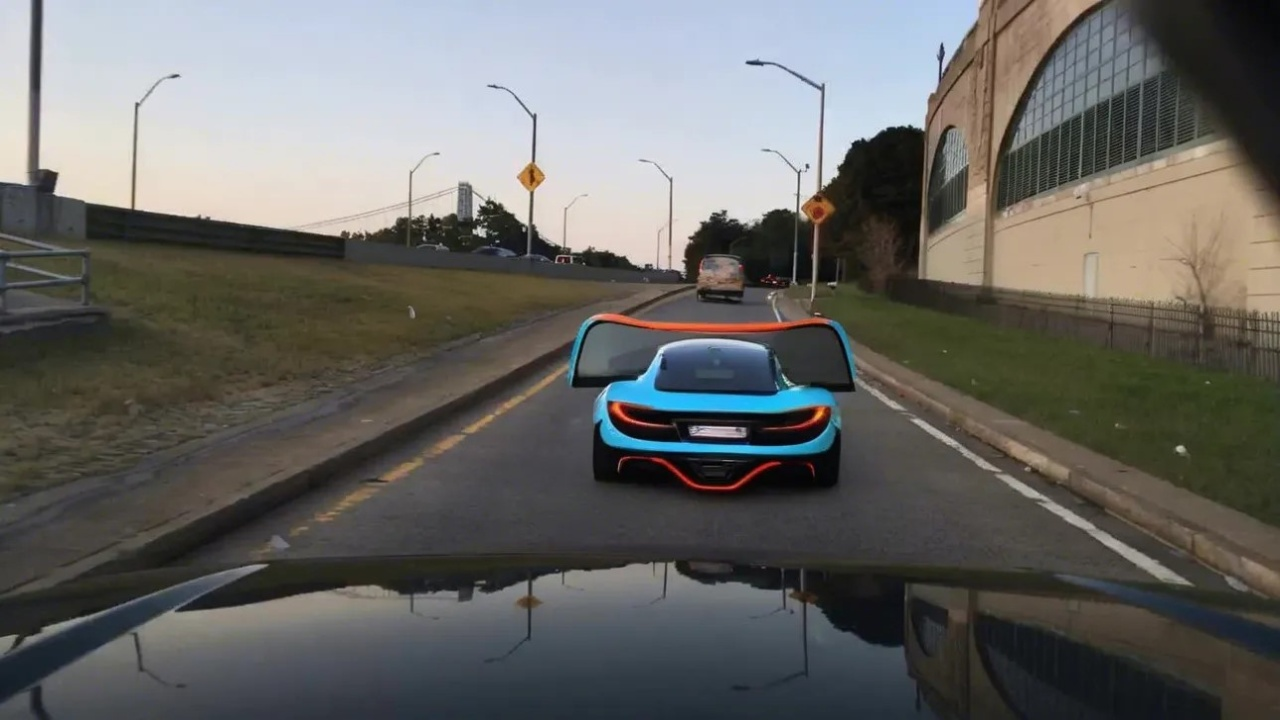
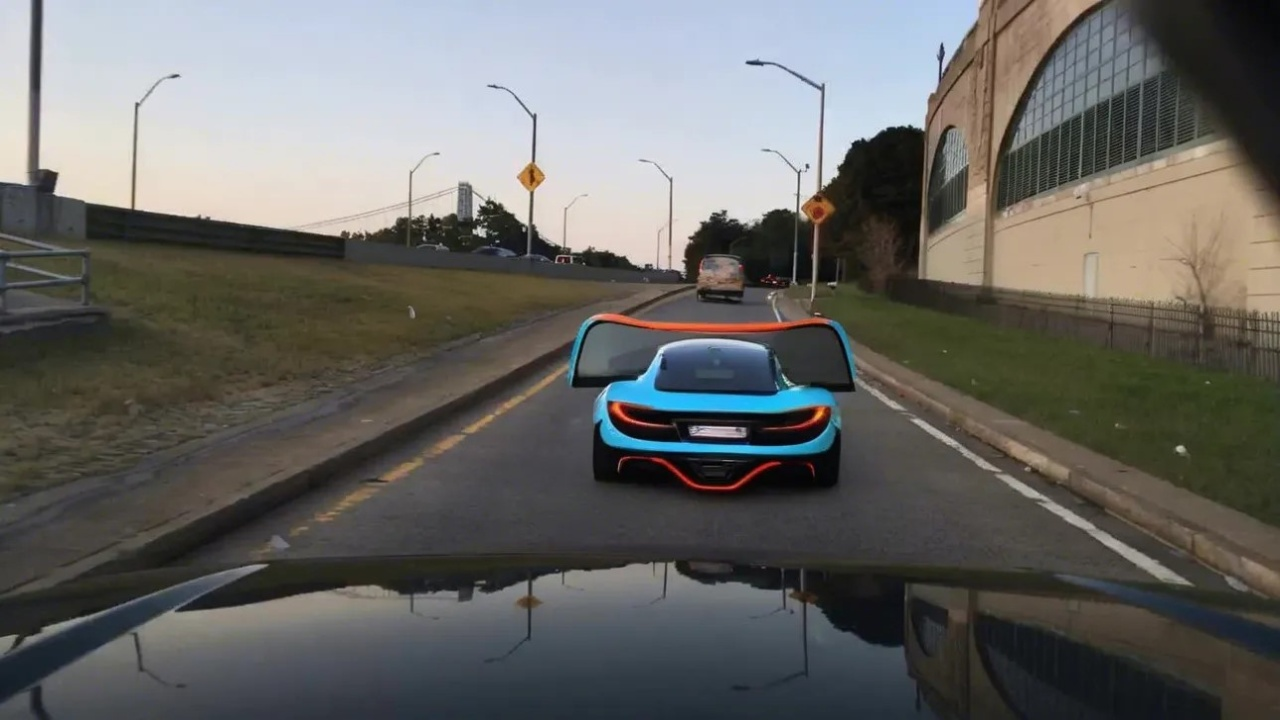

# **🌟 Introduction 🚀**

**The goal of this project is to classify autonomous driving scenes as either real or fake using deep learning techniques. While a simple label count (df['label'].value_counts()) can provide insights into the dataset's composition, it fails to address the critical aspects required for solving real-world problems:**

**1️⃣ Handling Unlabeled Test Data:**
In real-world scenarios, test data lacks labels. A trained model is essential to predict labels for unseen images.

**2️⃣ Capturing Complex Patterns:**
Real and fake images often differ in subtle ways (e.g., textures, lighting inconsistencies) that manual inspection or basic statistics cannot capture. Deep learning models, like CNNs, excel at extracting hierarchical features that differentiate real from fake images.

**3️⃣ Scalability and Automation:**
Manual classification becomes impractical for large datasets. A trained model can automate the process, ensuring consistency and efficiency across thousands or millions of images.

**4️⃣ Objective and Accurate Evaluation:**
Deep learning models allow for evaluation metrics like AUC-ROC, ensuring the solution generalizes well to unseen data, unlike subjective manual methods.

**🌐 Why Use Deep Learning with PyTorch?**

**Learning Hidden Representations:** CNNs in PyTorch extract detailed features such as edges, textures, and shapes, enabling robust classification.

**Scalability:** Models can process vast amounts of data and provide real-time predictions, making them ideal for real-world applications like autonomous vehicles or fraud detection.

**Validation on Unseen Data:** Training and validation splits ensure the model doesn't overfit, allowing it to generalize effectively.

**Confidence Scores:** The model provides probabilities, adding insights for decision-making processes.

# **📦🛠️Install Required Libraries**

In [1]:
pip install torch torchvision pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


# **📚Import Libraries**

In [2]:
import os
import torch
import torchvision
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import roc_auc_score
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# **🧹📊Data Preparation**


In [3]:
# Paths
df = pd.read_csv("/kaggle/input/cidaut-ai-fake-scene-classification-2024/train.csv")
train_dir = "/kaggle/input/cidaut-ai-fake-scene-classification-2024/Train"
test_dir = "/kaggle/input/cidaut-ai-fake-scene-classification-2024/Test"
sample_submission_csv = "/kaggle/input/cidaut-ai-fake-scene-classification-2024/sample_submission.csv"

In [4]:
df['label'].value_counts()

label
real       405
editada    315
Name: count, dtype: int64

**⚙️ Hyperparameters 🔧**

In [5]:
# Hyperparameters
batch_size = 32
epochs = 5
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**🎨 Feature Encoding 🔢**

In [6]:
label_encoder=LabelEncoder()
df['label']=label_encoder.fit_transform(df['label'])
print(f"Label Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


Label Mapping: {'editada': 0, 'real': 1}


# **🔄Train-Test Split**

In [7]:
train_data,val_data=train_test_split(df,test_size=0.20,random_state=42)

In [8]:
# Save split datasets to temporary CSV files (optional)
train_data.to_csv("train_split.csv", index=False)
val_data.to_csv("val_split.csv", index=False)


In [9]:

# Step 2: Dataset and Transforms
class DrivingSceneDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.data.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label



In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
# Initialize DataLoaders
train_dataset = DrivingSceneDataset("train_split.csv", train_dir, train_transform)
val_dataset = DrivingSceneDataset("val_split.csv", train_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# **🧠🔧Define Model**

In [12]:
# Model
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 1)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


# **⚙️📉Loss Function & Optimizer**

In [13]:
# Loss and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# **⏳Training Loop**

In [14]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 0.8474
Epoch 2/5, Loss: 0.6193
Epoch 3/5, Loss: 0.5129
Epoch 4/5, Loss: 0.3989
Epoch 5/5, Loss: 0.3514


In [15]:
# AUC-ROC Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)
            preds = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return roc_auc_score(all_labels, all_preds)



In [16]:
# Evaluate on Validation Set
val_auc = evaluate_model(model, val_loader)
print(f"Validation AUC-ROC: {val_auc:.4f}")


Validation AUC-ROC: 0.7510


# **📸Predictions**

In [17]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.images = sorted(
            [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        )
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.images[idx]  # Return image and filename


In [18]:
test_dataset = TestDataset(test_dir, val_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Make Predictions on Test Images
predictions = []
filenames = []

model.eval()
with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze(1)
        preds = torch.sigmoid(outputs).cpu().numpy()  # Convert to NumPy array
        predictions.extend(preds)
        filenames.extend(image_names)  # Collect filenames as strings


# **💾📜Save Result**

In [19]:
# Convert Predictions to Binary Labels (Threshold = 0.5)
binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

# Create Submission DataFrame
submission = pd.DataFrame({
    'image': filenames,  # Use the filenames directly
    'label': binary_predictions
})

# Save Submission File
submission.to_csv("submission.csv", index=False)


In [20]:
submission

,image,label
0,102.jpg,1
1,108.jpg,1
2,109.jpg,1
3,111.jpg,0
4,121.jpg,1
...,...,...
175,899.jpg,0
176,91.jpg,1
177,94.jpg,1
178,95.jpg,1


# **🌟 Conclusion 🎯**

**This project successfully classifies real vs. fake autonomous driving scenes using a fine-tuned ResNet-18 model in PyTorch.**

**1️⃣ Pipeline Overview:** Implemented an end-to-end workflow covering data preprocessing, train-test splitting, model training, predictions, and result submission.

**2️⃣ Model Used 🧠:** Fine-tuned ResNet-18 in PyTorch for binary classification of real vs. fake scenes.

**3️⃣ Preprocessing 📊:** Applied resizing, normalization, and augmentations; encoded labels (real, editada) numerically.

**4️⃣ Performance:** Achieved a validation **AUC-ROC of 0.6817** on an 80-20 train-validation split using Adam optimizer and BCEWithLogitsLoss.

**5️⃣ Test Predictions 📥:** Generated predictions on unseen test images, thresholded at 0.5, and saved results in the required competition format (submission.csv).

**6️⃣ Scalability & Automation 🚀:** Provided an efficient, scalable, and automated solution for large-scale real-world image classification challenges.

**This project showcases the power of deep learning for tackling complex classification tasks with accuracy and robustness. 🚗✨**